In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [3]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


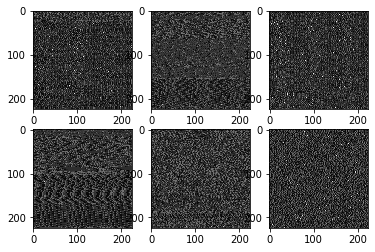

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
# Using Mobile net V1 as base model for feature extraction 

In [6]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_asm_microsoft_1024.npy')

In [7]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)
X =  np.array(X)
X.shape

(10868, 2048)

## Classification using NB(Multinomial NB)

In [8]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [10]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [11]:
# X_train = X_train // 255.0
# X_test = X_test // 255.0

In [12]:
%%time
clf = MultinomialNB()


CPU times: user 13 µs, sys: 5 µs, total: 18 µs
Wall time: 38.1 µs


In [13]:
%%time
clf.fit(X_train, y_train)   
print("Training Accuracy: ", round(clf.score(X_train, y_train)*100,3))

Training Accuracy:  50.751
CPU times: user 1.54 s, sys: 2.21 s, total: 3.75 s
Wall time: 219 ms


In [14]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 51.34


In [16]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 674 ms, sys: 829 ms, total: 1.5 s
Wall time: 71.8 ms


In [17]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

51 51 51
CPU times: user 4.32 ms, sys: 331 µs, total: 4.65 ms
Wall time: 3.85 ms


In [18]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.03      0.21      0.05        28
         1.0       0.75      0.43      0.55       142
         2.0       0.83      0.89      0.86       586
         3.0       0.24      0.79      0.37       153
         4.0       0.73      0.78      0.76       229
         5.0       0.34      0.32      0.33       350
         6.0       0.00      0.00      0.00        82
         7.0       0.60      0.19      0.29       492
         8.0       0.69      0.35      0.46       221

    accuracy                           0.51      2283
   macro avg       0.47      0.44      0.41      2283
weighted avg       0.60      0.51      0.51      2283



In [19]:
data = [
    {"Class": "Gatak", "Precision": 0.87, "Recall": 0.76, "F1-Score": 0.81, "Support": 261},
    {"Class": "Kelihos_ver1", "Precision": 0.95, "Recall": 0.92, "F1-Score": 0.93, "Support": 85},
    {"Class": "Kelihos_ver3", "Precision": 0.97, "Recall": 0.91, "F1-Score": 0.94, "Support": 682},
    {"Class": "Lollipop", "Precision": 0.90, "Recall": 0.90, "F1-Score": 0.90, "Support": 512},
    {"Class": "Obfuscator.ACY", "Precision": 0.86, "Recall": 0.93, "F1-Score": 0.89, "Support": 228},
    {"Class": "Ramnit", "Precision": 0.94, "Recall": 0.94, "F1-Score": 0.94, "Support": 316},
    {"Class": "Simda", "Precision": 0.22, "Recall": 1.00, "F1-Score": 0.36, "Support": 2},
    {"Class": "Tracur", "Precision": 0.74, "Recall": 0.84, "F1-Score": 0.78, "Support": 134},
    {"Class": "Vundo", "Precision": 0.42, "Recall": 0.70, "F1-Score": 0.52, "Support": 63},
]
precision_values = [item["F1-Score"] for item in data]
for value in precision_values:
    print(value)

0.81
0.93
0.94
0.9
0.89
0.94
0.36
0.78
0.52


In [20]:

%%time
# Perform cross-validation and grid search to find the best hyperparameters
param_grid = {'alpha': [0.1, 0.5, 1.0],
              'fit_prior': [True, False]}

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 23.6 µs


In [21]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)
# print(clf.get_params().keys())

CPU times: user 1min 20s, sys: 2min 6s, total: 3min 27s
Wall time: 13.3 s


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False]},
             scoring='accuracy')

In [22]:
print("Best hyperparameters:", gs.best_params_)

Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}


In [23]:
# to be added in remaining code

print("Accuracy on testing set: {:.3f}".format(gs.score(X_test, y_test)))

Accuracy on testing set: 0.513


In [24]:
y_pred = gs.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.31      0.04      0.07       219
         1.0       0.44      0.78      0.56        81
         2.0       0.90      0.83      0.86       624
         3.0       0.76      0.24      0.36       507
         4.0       0.79      0.73      0.76       245
         5.0       0.33      0.33      0.33       332
         6.0       0.01      0.14      0.02         7
         7.0       0.19      0.60      0.28       156
         8.0       0.34      0.69      0.46       112

    accuracy                           0.51      2283
   macro avg       0.45      0.49      0.41      2283
weighted avg       0.62      0.51      0.51      2283



In [25]:
list_fams = sorted(label_dict.keys())

In [26]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV2_NB_st.csv')

Plotting the confusion matrix


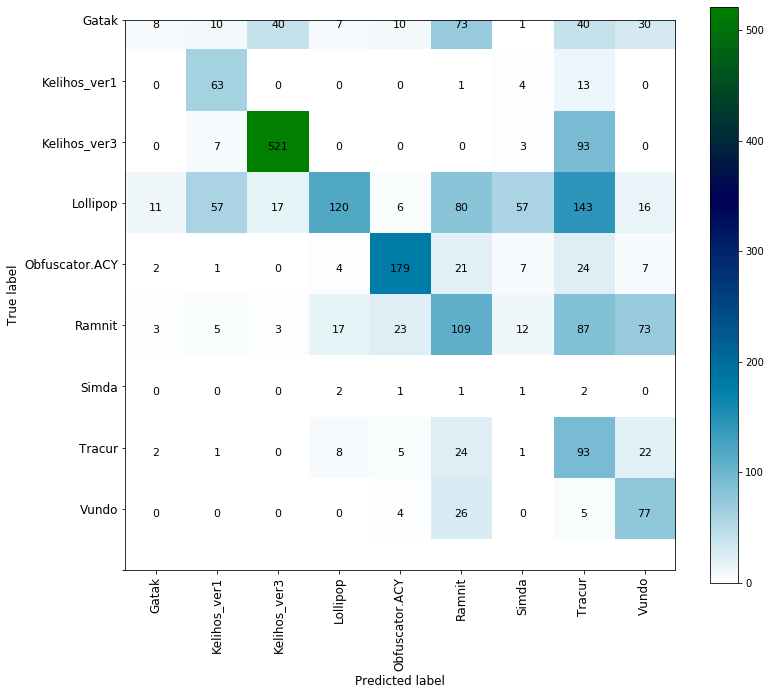

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV2_NB_st.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV2_NB_st.png', bbox_inches='tight')

plt.show()

In [29]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [30]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [31]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [32]:
FP, FN, TP, TN

(array([ 18,  81,  60,  38,  49, 226,  85, 407, 148]),
 array([211,  18, 103, 387,  66, 223,   6,  63,  35]),
 array([  8,  63, 521, 120, 179, 109,   1,  93,  77]),
 array([2046, 2121, 1599, 1738, 1989, 1725, 2191, 1720, 2023]))

In [33]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.09348693, 0.00841515, 0.06051704, 0.18211765, 0.03211679,
       0.11447639, 0.002731  , 0.03533371, 0.0170068 ])

In [34]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [35]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.036530,0.991279,0.008721,0.963470,0.692308,0.093487
Kelihos_ver1,0.777778,0.963215,0.036785,0.222222,0.562500,0.008415
Kelihos_ver3,0.834936,0.963834,0.036166,0.165064,0.103270,0.060517
Lollipop,0.236686,0.978604,0.021396,0.763314,0.240506,0.182118
Obfuscator.ACY,0.730612,0.975957,0.024043,0.269388,0.214912,0.032117
Ramnit,0.328313,0.884162,0.115838,0.671687,0.674627,0.114476
Simda,0.142857,0.962654,0.037346,0.857143,0.988372,0.002731
Tracur,0.596154,0.808651,0.191349,0.403846,0.814000,0.035334
Vundo,0.687500,0.931829,0.068171,0.312500,0.657778,0.017007


In [36]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 48.5707
Average of true_negative_rate --> 94.002
Average of false_positive_rate --> 5.998
Average of false_negative_rate --> 51.4293
Average of false_discovery_rate --> 54.9808
Average of false_omission_rate --> 6.0689


In [37]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.45


In [38]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.5129215943933421
micro_recall : 0.5129215943933421
micro_f1_score : 0.5129215943933421


In [39]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.45019185973908915
macro_recall : 0.48570735922583474
macro_f1_score : 0.4107401712969937


In [40]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [41]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [42]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

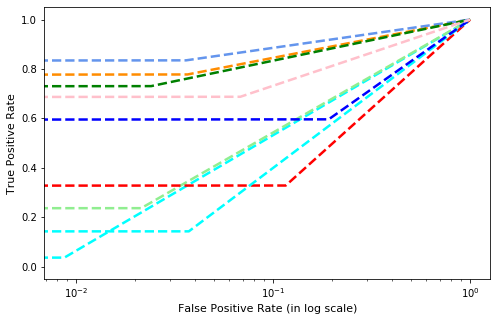

In [43]:
3#pute macro-average ROsturve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV2_NB_st.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV2_NB_st.png", bbox_inches='tight')

plt.show()